##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# MoveNet: Ultra fast and accurate pose detection model.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/movenet"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=movenet"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

**[MoveNet](https://t.co/QpfnVL0YYI?amp=1)** is an ultra fast and accurate model that detects 17 keypoints of a body. The model is offered on [TF Hub](https://tfhub.dev/s?q=movenet) with two variants, known as Lightning and Thunder. Lightning is intended for latency-critical applications, while Thunder is intended for applications that require high accuracy. Both models run faster than real time (30+ FPS) on most modern desktops, laptops, and phones, which proves crucial for live fitness, health, and wellness applications.


<img src="https://github.com/tensorflow/tfjs-models/raw/master/pose-detection/assets/combined_squat_dance.gif" alt="drawing"/>

*Images downloaded from Pexels (https://www.pexels.com/)

This Colab walks you through the details of how to load MoveNet, and run inference on the input image and video below.

Note: check out the [live demo](https://storage.googleapis.com/tfjs-models/demos/pose-detection/index.html?model=movenet) for how the model works!

# Human Pose Estimation with MoveNet

## Visualization libraries & Imports

In [2]:
#!pip install -q imageio
#!pip install -q opencv-python
#!pip install -q git+https://github.com/tensorflow/docs

In [3]:
#!pip install tensorflow_hub

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [5]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'fuchsia',
    (7, 9): 'fuchsia',
    (6, 8): 'darkcyan',
    (8, 10): 'darkcyan',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

## Load Model from TF hub

In [6]:
model_name = "movenet_thunder" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

## Single Image Example

This session demonstrates the minumum working example of running the model on a **single image** to predict the 17 human keypoints.

### Load Input Image

In [7]:
#!curl -o input_image.jpeg https://images.pexels.com/photos/4384679/pexels-photo-4384679.jpeg --silent

In [7]:
# Load the input image.
image_path = 'input_image.jpeg'
image_path = 'mpii_human_pose_v1/images/'+'097586526.jpg'
#image_path = 'photo_5863763457768276834_y.jpg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: mpii_human_pose_v1/images/097586526.jpg : Impossibile trovare il percorso specificato.
; No such process [Op:ReadFile]

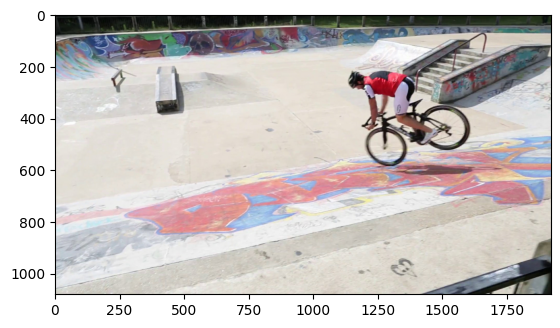

In [9]:
plt.imshow(image)

### Run Inference

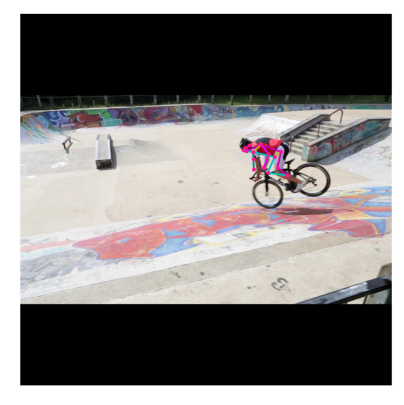

In [10]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

(0.0, 1.0)

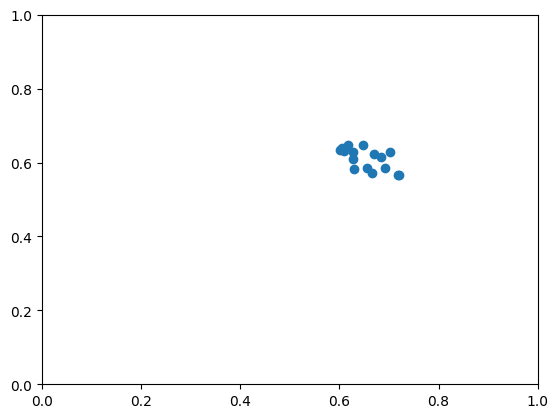

In [11]:
plt.scatter( keypoints_with_scores.reshape(17,3)[:,:2][:,1], 1-keypoints_with_scores.reshape(17,3)[:,:2][:,0] )
plt.xlim(0,1)
plt.ylim(0,1)

In [10]:
import scipy.io
notes = scipy.io.loadmat('mpii_human_pose_v1_u12_1.mat')

In [11]:
import pandas as pd

df = pd.DataFrame({'class': np.array( notes['RELEASE']['act'][0,0]['act_id'][:,0], dtype='int'), 
                   'name': np.array( np.concatenate(notes['RELEASE']['annolist'][0,0]['image'][0])['name'][:,0],
                                    dtype='object' )})
dfc = df[df['class'] != -1]

grouped_counts = dfc.groupby('class').size().reset_index(name='Count')
sorted_counts = grouped_counts.sort_values(by='Count', ascending=False)

In [12]:
df_93 = dfc[dfc['class']==93]
df_378 = dfc[dfc['class']==378]

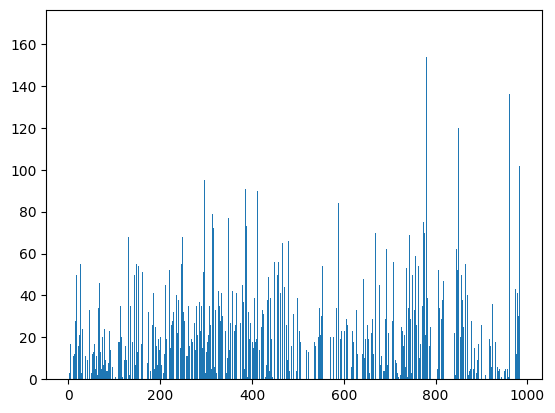

In [13]:
hist = plt.hist(dfc['class'], bins=np.arange(1,max(dfc['class'])+1))
plt.show()

In [8]:
# Load the .npz file into a dictionary
file_path = 'my_dict.npz'
loaded_data = np.load(file_path)

# Access individual arrays from the loaded data
loaded_dict = {key: loaded_data[key] for key in loaded_data.files}

print("Loaded dictionary with NumPy arrays:")#, loaded_dict)

Loaded dictionary with NumPy arrays:


In [23]:
#data = np.array( np.concatenate(notes['RELEASE']['annolist'][0,0]['image'][0])['name'][:,0], dtype='object' )
#keypoints_list = {}
#for i, image_name in enumerate(data):
    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    file_name = str(image_name[0])
    image_path = 'mpii_human_pose_v1/images/' + file_name
    try: 
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image)
        input_image = tf.expand_dims(image, axis=0)
        input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
        keypoints_list[file_name] = movenet(input_image).reshape(17,3)
    except:
        print(file_name)

040348287.jpg
013401523.jpg
002878268.jpg


In [29]:
'''# Specify the file path where you want to save the .npz file
file_path = 'my_dict.npz'

# Save the dictionary with NumPy arrays to the .npz file
np.savez(file_path, **keypoints_list)

print(f"Dictionary with NumPy arrays saved to {file_path}")'''

'# Specify the file path where you want to save the .npz file\nfile_path = \'my_dict.npz\'\n\n# Save the dictionary with NumPy arrays to the .npz file\nnp.savez(file_path, **keypoints_list)\n\nprint(f"Dictionary with NumPy arrays saved to {file_path}")'

In [16]:
# List of keys you want to select
keys_to_select = df_93['name']

keyp93 = {}

for key in keys_to_select:
    if key[0] in loaded_dict:
        keyp93[key[0]] = loaded_dict[key[0]]

#print(keyp93)

# List of keys you want to select
keys_to_select = df_378['name']

keyp378 = {}

for key in keys_to_select:
    if key[0] in loaded_dict:
        keyp378[key[0]] = loaded_dict[key[0]]

#print(keyp378)

In [82]:
a93 = np.array( list(keyp93.values()) )[:,:,:2]
a378 = np.array( list(keyp378.values()) )[:,:,:2]
data = np.vstack((a93, a378))

#normalization
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

norm_data = np.empty_like(data)

for i in range(arr.shape[0]):
    norm_data[i] = scaler.fit_transform(data[i])

In [84]:
#reshape
norm_data = norm_data.reshape(data.shape[0],data.shape[1]*data.shape[2])
labels = np.array( [0 if i<a93.shape[0] else 1 for i in range(data.shape[0])] )

In [85]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Assuming you have a list of pairs (label, data)
# Let's generate a random dataset as an example
np.random.seed(42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(norm_data, labels, test_size=0.2, random_state=42)

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8769230769230769


In [87]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(norm_data, labels, test_size=0.2)#, random_state=42)

# Build the neural network model
model = Sequential()
model.add(Dense(X_train.shape[0], input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(X_train.shape[0]/2, activation='relu'))
model.add(Dense(X_train.shape[0]/4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch 1/100
7/7 [==============================] - 2s 58ms/step - loss: 0.6801 - accuracy: 0.5652 - val_loss: 0.6378 - val_accuracy: 0.5577
Epoch 2/100
7/7 [==============================] - 0s 14ms/step - loss: 0.6209 - accuracy: 0.6618 - val_loss: 0.5887 - val_accuracy: 0.8269
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 0.5683 - accuracy: 0.8116 - val_loss: 0.5204 - val_accuracy: 0.8654
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 0.5255 - accuracy: 0.7778 - val_loss: 0.4869 - val_accuracy: 0.6923
Epoch 5/100
7/7 [==============================] - 0s 13ms/step - loss: 0.4799 - accuracy: 0.8068 - val_loss: 0.4207 - val_accuracy: 0.8269
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 0.4251 - accuracy: 0.8309 - val_loss: 0.4277 - val_accuracy: 0.7308
Epoch 7/100
7/7 [==============================] - 0s 14ms/step - loss: 0.4265 - accuracy: 0.8068 - val_loss: 0.3599 - val_accuracy: 0.8462
Epoch 8/100
7/7 [===

7/7 [==============================] - 0s 14ms/step - loss: 0.2481 - accuracy: 0.9082 - val_loss: 0.2291 - val_accuracy: 0.8846
Epoch 60/100
7/7 [==============================] - 0s 15ms/step - loss: 0.2427 - accuracy: 0.9130 - val_loss: 0.2395 - val_accuracy: 0.8654
Epoch 61/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2452 - accuracy: 0.9082 - val_loss: 0.2287 - val_accuracy: 0.8846
Epoch 62/100
7/7 [==============================] - 0s 13ms/step - loss: 0.2780 - accuracy: 0.8937 - val_loss: 0.2459 - val_accuracy: 0.8846
Epoch 63/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2500 - accuracy: 0.9130 - val_loss: 0.2096 - val_accuracy: 0.9038
Epoch 64/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2354 - accuracy: 0.9130 - val_loss: 0.2251 - val_accuracy: 0.8654
Epoch 65/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2350 - accuracy: 0.9275 - val_loss: 0.2324 - val_accuracy: 0.8846
Epoch 66/100
7/7 [========

In [112]:
# List of keys you want to select
keyp = {}

labels = []
for key in keys_to_select:
    if key[0] in loaded_dict:
        labels.append(dfc[dfc['name']==key[0]]['class'])
        keyp[key[0]] = loaded_dict[key[0]]

#normalization
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

data = np.array( list(keyp.values()) )[:,:,:2]
norm_data = np.empty_like(data)

for i in range(arr.shape[0]):
    norm_data[i] = scaler.fit_transform(data[i])
    
norm_data = norm_data.reshape(data.shape[0],data.shape[1]*data.shape[2])

KeyboardInterrupt: 

In [108]:
import numpy as np
from sklearn.cluster import KMean
import matplotlib.pyplot as plt

labels = np.array(labels)
# Specify the number of clusters (K)
num_clusters = len(labels.unique())

# Initialize the KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(norm_data)

# Get the predicted cluster labels
predicted_labels = kmeans.labels_

# Compute accuracy against true labels
accuracy = accuracy_score(labels, predicted_labels)

print(f'Accuracy: {accuracy:.4f}')

C:\Users\prontoalluso\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\prontoalluso\AppData\Local\Temp\ipykernel_6992\3977388010.py:12: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (629). Possibly due to duplicate points in X.
  kmeans.fit(norm_data)


ValueError: Found input variables with inconsistent numbers of samples: [18032, 18030]